## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

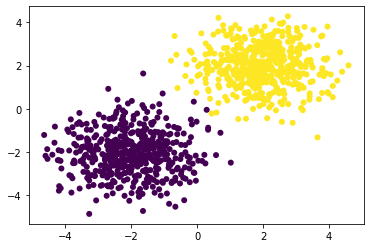

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

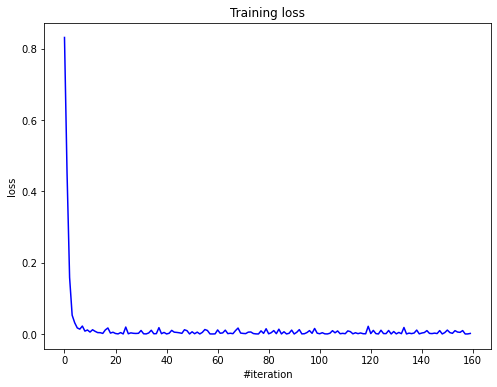

Current loss: 0.001525


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [9]:
def one_hot_encode(input, classes=10):
    one_hot_targets = np.eye(classes)[input]
    return one_hot_targets

y_train_enc = one_hot_encode(y_train)
y_val_enc = one_hot_encode(y_val)
y_test_enc = one_hot_encode(y_test)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [10]:
relu = Sequential()
relu.add(Flatten())
relu.add(Linear(28*28, 100))
relu.add(ReLU())
relu.add(Linear(100, 10))
relu.add(LogSoftMax())

elu = Sequential()
elu.add(Flatten())
elu.add(Linear(28*28, 100))
elu.add(ELU())
elu.add(Linear(100, 10))
elu.add(LogSoftMax())

leaky = Sequential()
leaky.add(Flatten())
leaky.add(Linear(28*28, 100))
leaky.add(LeakyReLU())
leaky.add(Linear(100, 10))
leaky.add(LogSoftMax())

soft = Sequential()
soft.add(Flatten())
soft.add(Linear(28*28, 100))
soft.add(SoftPlus())
soft.add(Linear(100, 10))
soft.add(LogSoftMax())

In [11]:
def get_batches(dataset, batch_size):
    X, Y = dataset
        
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    for start in range(0, X.shape[0], batch_size):
        end = min(start + batch_size, X.shape[0])
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [12]:
from tqdm import tqdm
import time

def NN_predict(model, X, y, X_t, y_t, y_test, criterion=ClassNLLCriterion(), n_epochs=20, batch_size=128):
    losses = []
    
    optimizer_config = {'learning_rate' : 0.001, 'momentum': 0.9}
    optimizer_state = {}
    
    start_time = time.time()
    
    for _ in tqdm(range(n_epochs)):
        for x_batch, y_batch in get_batches((X, y), batch_size):
            
            model.zeroGradParameters()
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)

            sgd_momentum(model.getParameters(), 
                         model.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            losses.append(loss)
    
    end_time = time.time()
    exec_time = end_time - start_time
        
    y_predicted = np.argmax(model.forward(X_t), axis=1)
    accuracy = np.mean(y_predicted == y_test)
    
    print('Got loss: ' + str(loss))
    print('Got accuracy: ' + str(accuracy))
    print('Got exec time: ' + str(exec_time))
    
    return losses, accuracy, exec_time

In [13]:
relu_losses, relu_acc, relu_time = NN_predict(relu, X_train, y_train_enc, X_test, y_test_enc, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.52s/it]

Got loss: 0.5477730967413486
Got accuracy: 0.9267
Got exec time: 30.47900366783142


In [14]:
elu_losses, elu_acc, elu_time = NN_predict(elu, X_train, y_train_enc, X_test, y_test_enc, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.63s/it]

Got loss: 0.2895740413987096
Got accuracy: 0.919
Got exec time: 32.507535219192505


In [15]:
leaky_losses, leaky_acc, leaky_time = NN_predict(leaky, X_train, y_train_enc, X_test, y_test_enc, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.50s/it]

Got loss: 0.5186711562301474
Got accuracy: 0.9249
Got exec time: 29.92707109451294


In [16]:
soft_losses, soft_acc, soft_time = NN_predict(soft, X_train, y_train_enc, X_test, y_test_enc, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.88s/it]


Got loss: 0.3192760205722988
Got accuracy: 0.9152
Got exec time: 37.514644145965576


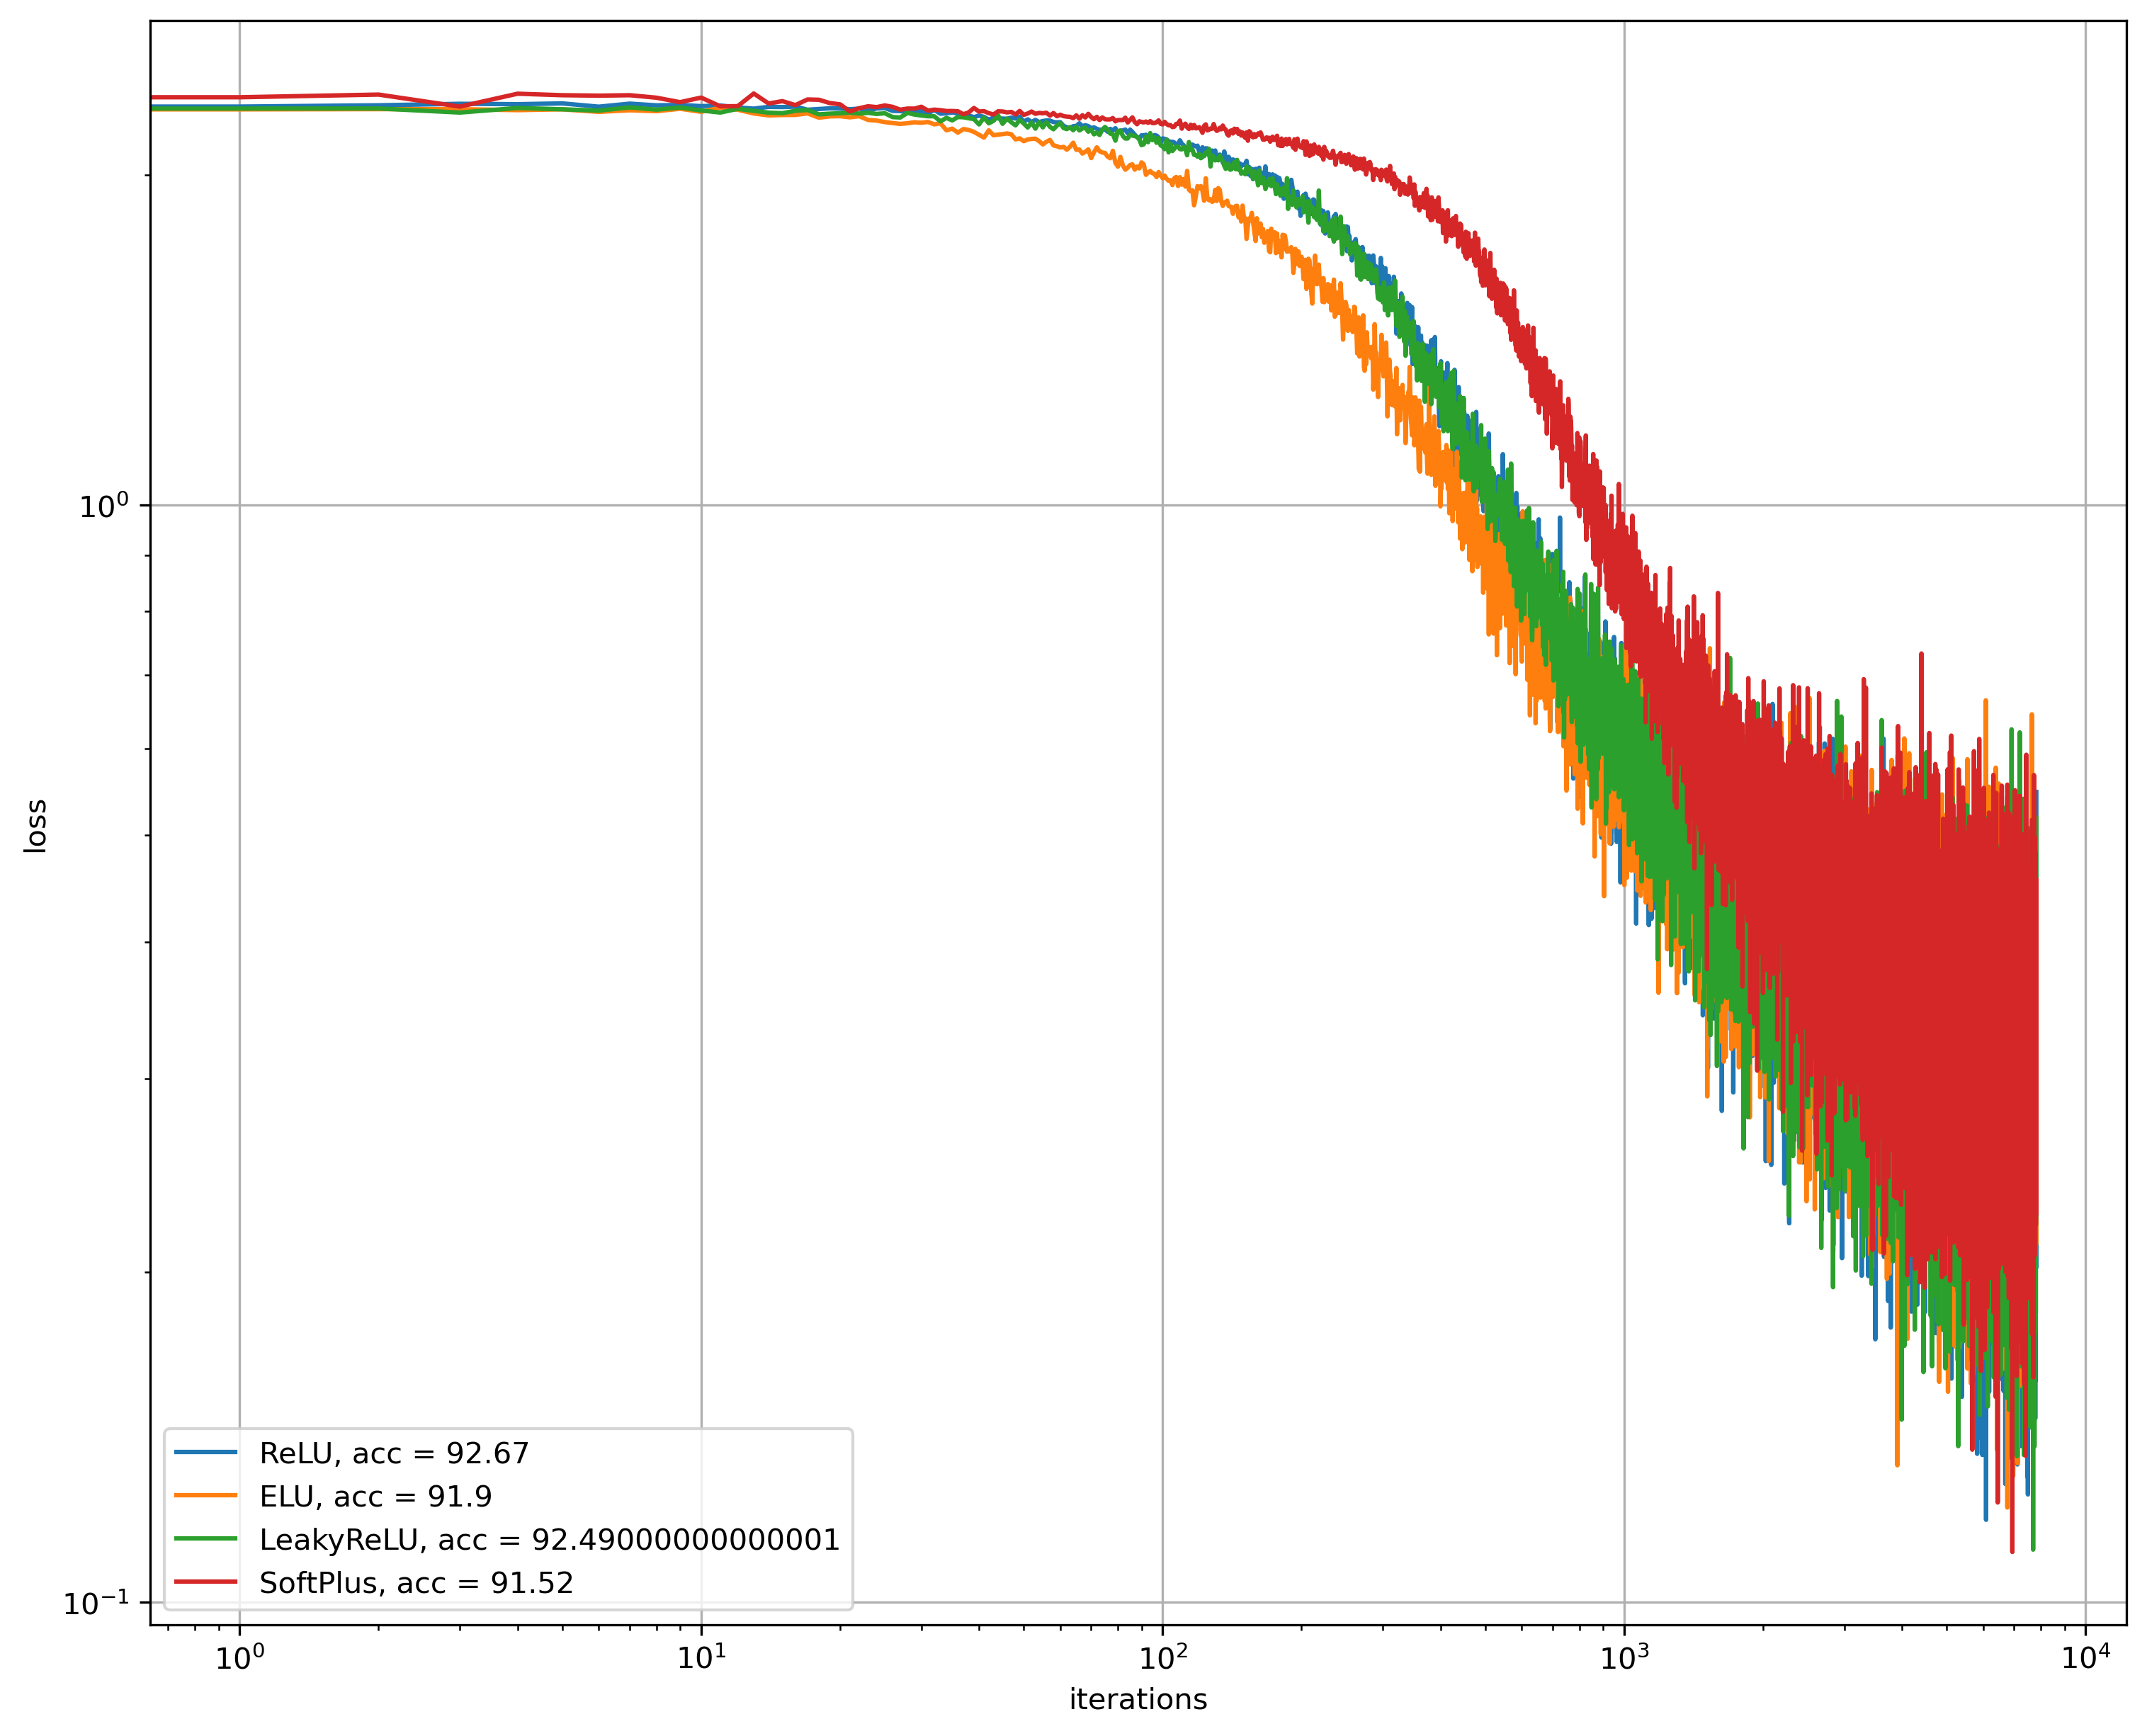

In [17]:
plt.figure(figsize=(12, 10), dpi=300)
plt.yscale('log')
plt.xscale('log')
plt.plot(relu_losses, label = "ReLU, acc = " + str(relu_acc * 100))
plt.plot(elu_losses, label = "ELU, acc = " + str(elu_acc * 100))
plt.plot(leaky_losses, label = "LeakyReLU, acc = " + str(leaky_acc * 100))
plt.plot(soft_losses, label = "SoftPlus, acc = " + str(soft_acc * 100))
plt.grid()
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()

Наилучшее качество показывает ReLU, однако отличается всего на 0.18% от LeakyReLU, которая работает немного быстрее.

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [18]:
relu_batch = Sequential()
relu_batch.add(Flatten())
relu_batch.add(Linear(28*28, 100))
relu_batch.add(BatchNormalization(alpha = 0.99))
relu_batch.add(ChannelwiseScaling(100))
relu_batch.add(ReLU())
relu_batch.add(Linear(100, 10))
relu_batch.add(LogSoftMax())

In [19]:
relu_batch_losses, relu_batch_acc, relu_batch_time = NN_predict(relu_batch, X_train, y_train_enc, X_test, y_test_enc, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.65s/it]

Got loss: 0.09942297897255735
Got accuracy: 0.9632
Got exec time: 32.935133934020996


Посмотрим, что изменилось с добавлением дополнительного слоя с нормализацией и скейлингом:

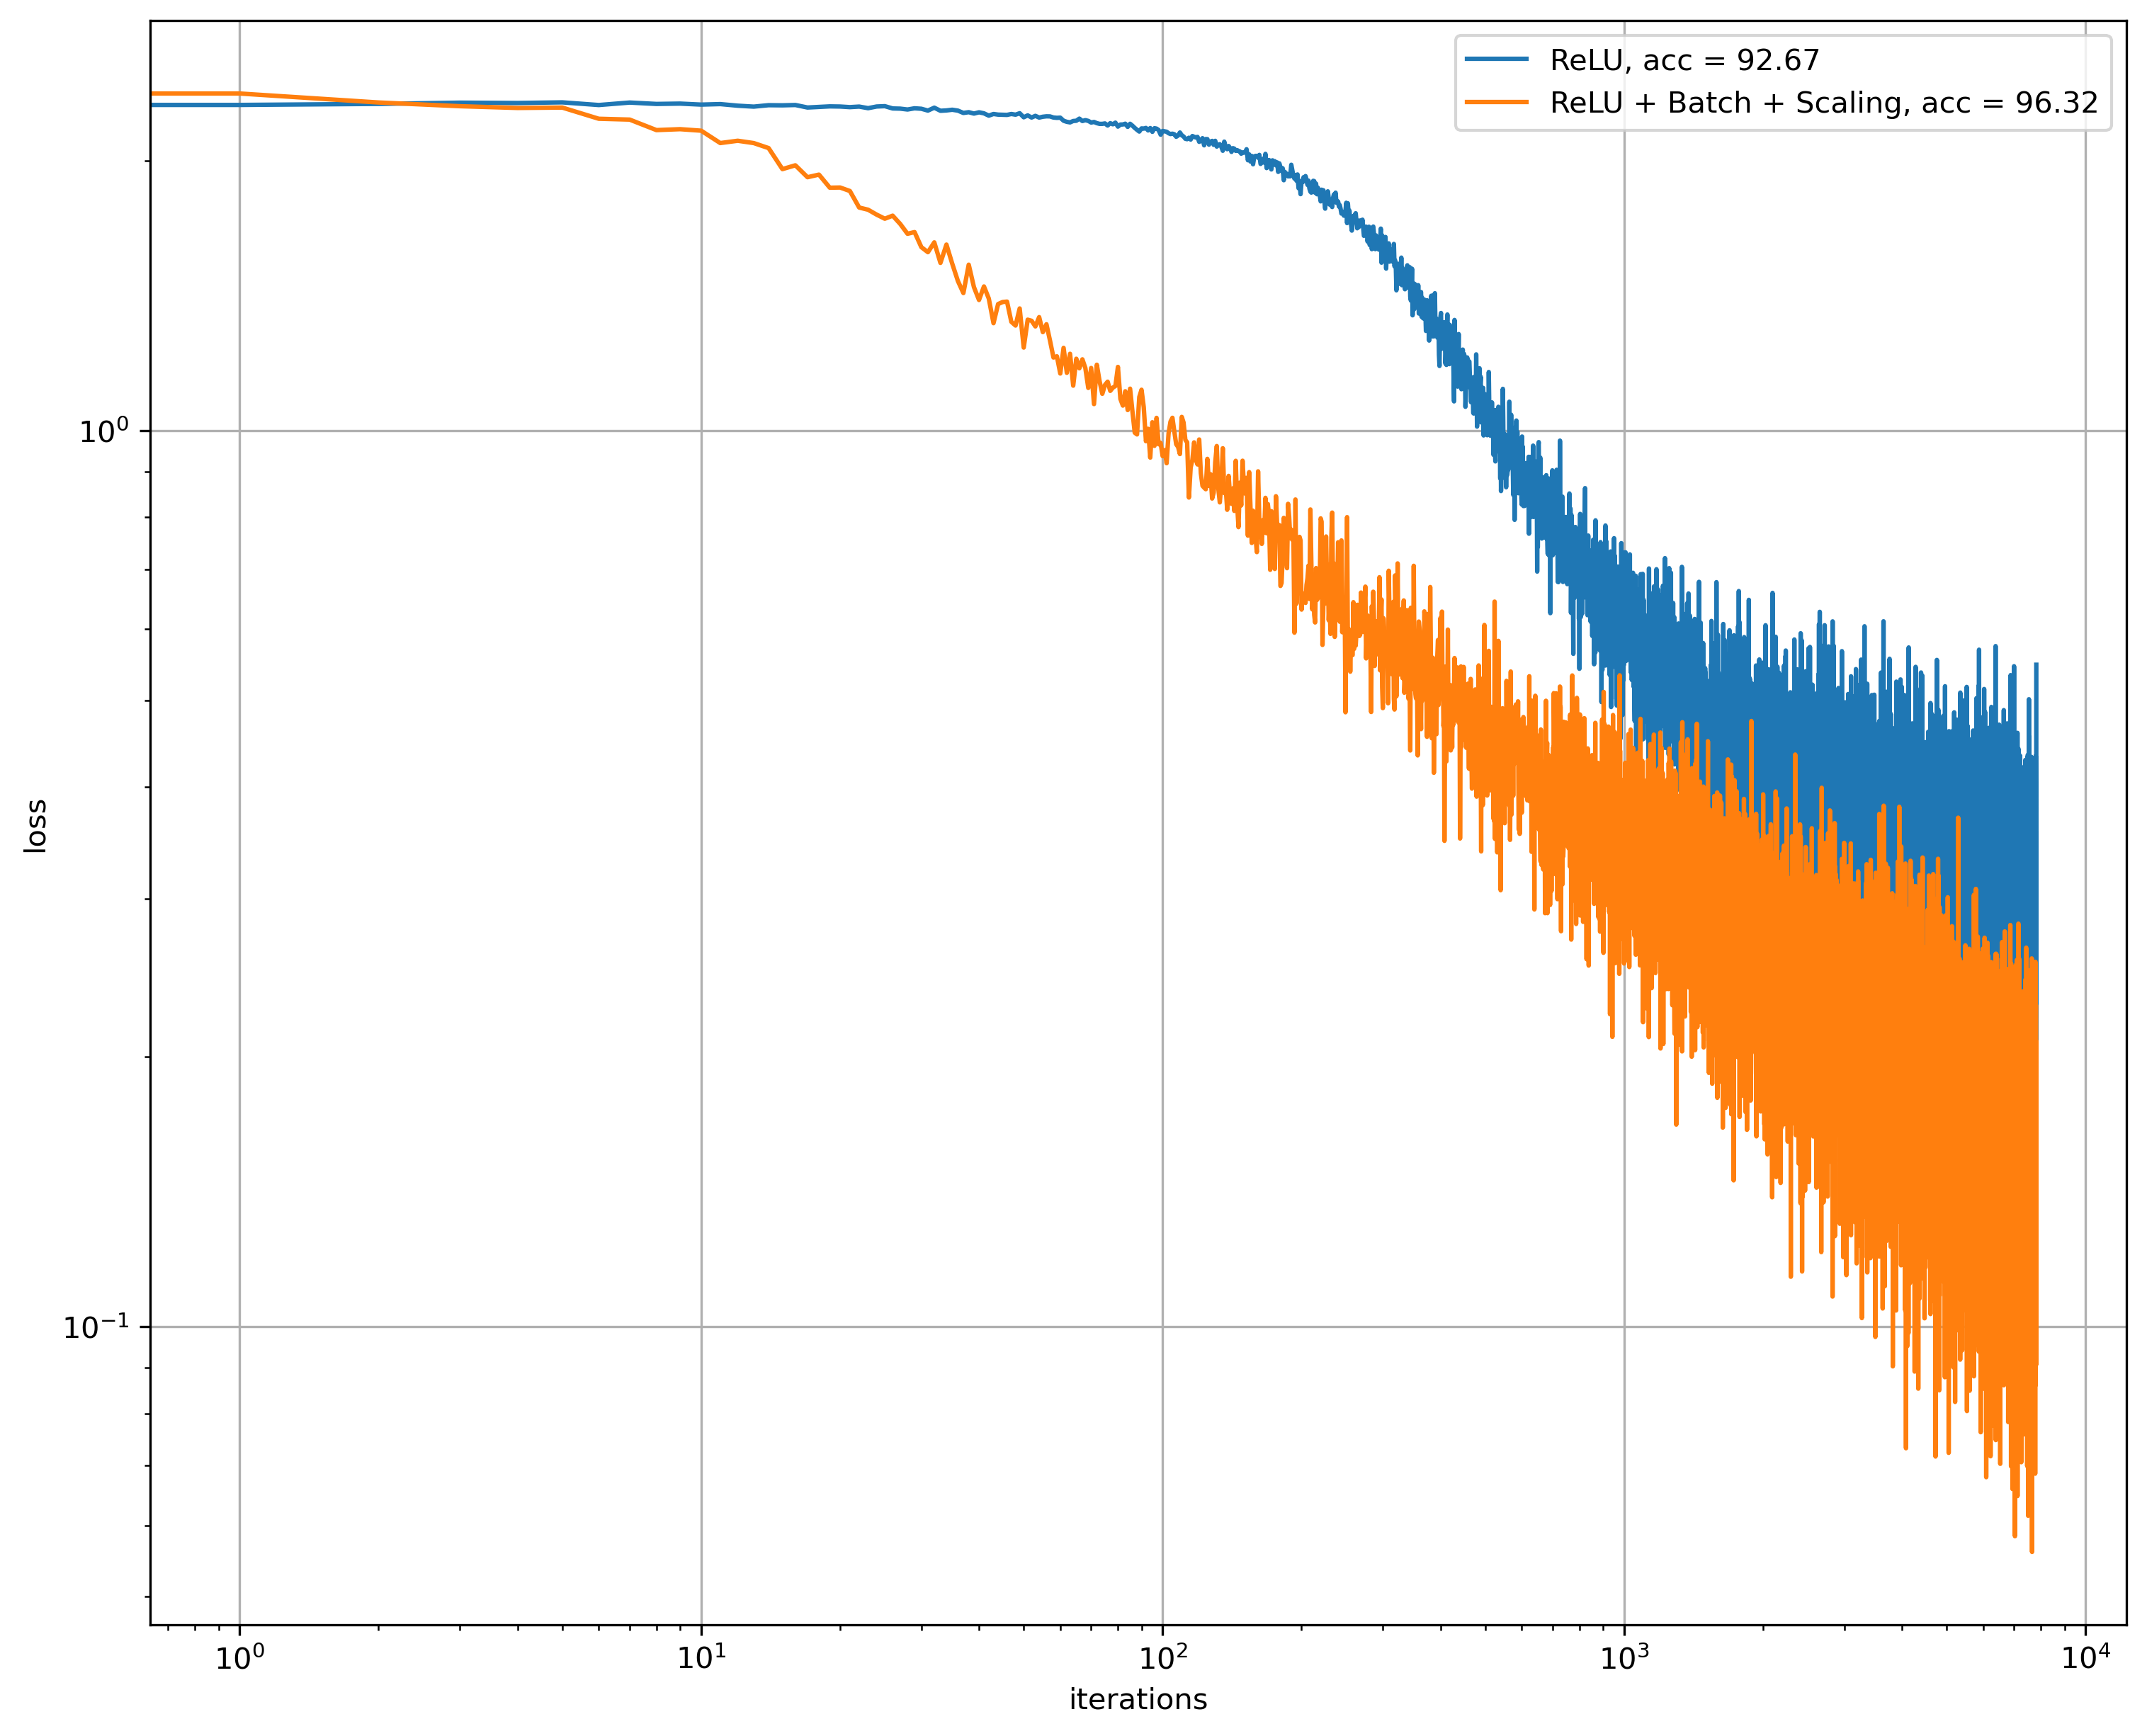

In [22]:
plt.figure(figsize=(12, 10), dpi=300)
plt.yscale('log')
plt.xscale('log')
plt.plot(relu_losses, label = "ReLU, acc = " + str(relu_acc * 100))
plt.plot(relu_batch_losses, label = "ReLU + Batch + Scaling, acc = " + str(relu_batch_acc * 100))
plt.grid()
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()

Видим улучшение качества на 4% и явное уменьшение loss в зависимости от числа итераций. Однако по времени комбинированная версия работает немного дольше.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Добавим еще дропаут к вышеописанной архитектуре.

In [24]:
final_model = Sequential()
final_model.add(Flatten())
final_model.add(Linear(28*28, 100))
final_model.add(BatchNormalization(alpha = 0.99))
final_model.add(ChannelwiseScaling(100))
final_model.add(Dropout(0.5))
final_model.add(ReLU())
final_model.add(Linear(100, 10))
final_model.add(LogSoftMax())

In [25]:
def NN_predict_2(model, X, y, X_t, y_t, y_test, criterion=ClassNLLCriterion(), learning_rate=0.001, n_epochs=20, batch_size=128):
    losses = []
    
    optimizer_config = {'learning_rate' : learning_rate, 'momentum': 0.9}
    optimizer_state = {}
    
    start_time = time.time()
    
    for _ in tqdm(range(n_epochs)):
        model.train()
        for x_batch, y_batch in get_batches((X, y), batch_size):
            
            model.zeroGradParameters()
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)

            sgd_momentum(model.getParameters(), 
                         model.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            losses.append(loss)
            
        model.evaluate()
    
    end_time = time.time()
    exec_time = end_time - start_time
        
    y_predicted = np.argmax(model.forward(X_t), axis=1)
    accuracy = np.mean(y_predicted == y_test)
    
    print('Got loss: ' + str(loss))
    print('Got accuracy: ' + str(accuracy))
    print('Got exec time: ' + str(exec_time))
    
    return losses, accuracy, exec_time

Проиграемся с learning rate:

In [27]:
learning_rate = [0.9, 0.5, 0.1, 0.01, 0.001, 0.0001]
accuracies = []


for lr in learning_rate:
    _, acc, _ = NN_predict_2(final_model, X_train, y_train_enc, X_test, y_test_enc, y_test, learning_rate=lr)
    accuracies.append(acc)

  0%|                                                                                  | 0/20 [00:00<?, ?it/s]

Got loss: 0.1032572619620931
Got accuracy: 0.9671
Got exec time: 43.22193789482117


  0%|                                                                                  | 0/20 [00:00<?, ?it/s]

Got loss: 0.04286015482675905
Got accuracy: 0.9699
Got exec time: 43.079179525375366


  0%|                                                                                  | 0/20 [00:00<?, ?it/s]

Got loss: 0.18694129987664873
Got accuracy: 0.9729
Got exec time: 43.538196325302124


  0%|                                                                                  | 0/20 [00:00<?, ?it/s]

Got loss: 0.10869633376722557
Got accuracy: 0.9733
Got exec time: 44.33670973777771


  0%|                                                                                  | 0/20 [00:00<?, ?it/s]

Got loss: 0.22038243122832646
Got accuracy: 0.9737
Got exec time: 45.147639751434326


100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.36s/it]

Got loss: 0.2190761302219419
Got accuracy: 0.9734
Got exec time: 47.279242515563965


In [31]:
import pandas as pd

results = pd.DataFrame({'learning_rate': learning_rate,
                       'accuracy': accuracies}).sort_values(by=['accuracy'], ascending=False)
results

,learning_rate,accuracy
4,0.0010,0.9737
5,0.0001,0.9734
3,0.0100,0.9733
2,0.1000,0.9729
1,0.5000,0.9699
0,0.9000,0.9671


Итого, лучший результат показывает `learning_rate = 0.001` (мы его и использовали ранее). Попробуем разное количество эпох, вероятно, результат получится лучше:

In [32]:
n_epochs = [10, 20, 30, 40, 50]
accuracies = []


for e in n_epochs:
    _, acc, _ = NN_predict_2(final_model, X_train, y_train_enc, X_test, y_test_enc, y_test, n_epochs=e)
    accuracies.append(acc)

  0%|                                                                                  | 0/20 [00:00<?, ?it/s]

Got loss: 0.05950635843887551
Got accuracy: 0.9734
Got exec time: 21.133304595947266


  0%|                                                                                  | 0/30 [00:00<?, ?it/s]

Got loss: 0.14235407194135968
Got accuracy: 0.973
Got exec time: 42.91104602813721


  0%|                                                                                  | 0/40 [00:00<?, ?it/s]

Got loss: 0.08212921326334824
Got accuracy: 0.9732
Got exec time: 65.29363703727722


  0%|                                                                                  | 0/50 [00:00<?, ?it/s]

Got loss: 0.07851196390575885
Got accuracy: 0.9735
Got exec time: 86.04393148422241


100%|█████████████████████████████████████████████████████████████████████████| 50/50 [01:52<00:00,  2.26s/it]

Got loss: 0.11180461028503075
Got accuracy: 0.9735
Got exec time: 112.80363440513611


От количества эпох ничего особо не зависит.

Print here your accuracy on test set. It should be around 90%.

In [36]:
print("Best got accuracy: " + str(results['accuracy'][4] * 100) + "%")

Best got accuracy: 97.37%


Видим, что получилось с помощью DropOut улучшить качество на 1% по сравнению с архитектурой без dropout.

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [37]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

y_train.shape, y_test.shape, y_val.shape

((50000,), (10000,), (10000,))

In [39]:
from sklearn.preprocessing import OneHotEncoder

X_train = X_train.reshape(-1, 28 * 28)
X_val = X_val.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = enc.fit_transform(y_val.reshape(-1, 1)).toarray()

In [40]:
y_train.shape

(50000, 10)

In [41]:
from torch import nn
from torch import optim
import torch

In [42]:
torch_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 100),
    nn.BatchNorm1d(100),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
)

In [44]:
losses = []

n_epochs = 20
batch_size = 128

criterion = nn.NLLLoss()
optimizer = optim.SGD(torch_model.parameters(), lr=0.001, momentum=0.9)
torch_model.train(True)

start_time = time.time()

for _ in tqdm(range(n_epochs)):
    for x_batch, y_batch in get_batches((torch.FloatTensor(X_train), torch.Tensor(y_train)), batch_size):
        
        optimizer.zero_grad()
        
        predictions = torch_model.forward(x_batch)
        loss = criterion(predictions, torch.max(y_batch, 1)[1])
        loss.backward()
        optimizer.step()
        
        losses.append(loss)
        
end_time = time.time()
exec_time = end_time - start_time

print('Got loss: ' + str(loss))
print('Got exec time: ' + str(exec_time))

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.42s/it]

Got loss: tensor(0.3295, grad_fn=<NllLossBackward0>)
Got exec time: 28.373178243637085


Видим, что реализация torch работает быстрее: 28.37 vs 45.14.  

Посмотрим, что по качеству:

In [47]:
from sklearn.metrics import accuracy_score

torch_model.eval()

answers = []
labels = []

with torch.no_grad():
    for x_batch, y_batch in get_batches((X_test, torch.Tensor(y_test)), batch_size):
        predictions = torch_model.forward(torch.FloatTensor(x_batch))
        prediction = predictions.argmax(axis=1).reshape(-1, 1)
        answers.append(prediction)
        labels.append(y_batch.reshape(-1, 1))

answers = np.vstack(answers)
labels = np.vstack(labels)

print('Got acccuracy: ' + str(accuracy_score(answers, labels) * 100) + '%')

Got acccuracy: 96.09%


Наша реализация показала качество на 1% (с небольшим) выше, однако сильно проиграла в скорости.